# FastAI Example

> FASTAI Example

In [ ]:
#| default_exp fastai

## Check for all installs and versions

In [ ]:
!conda list | grep "pytorch"

ffmpeg                    4.3                  hf484d3e_0    pytorch
libjpeg-turbo             2.0.0                h9bf148f_0    pytorch
pytorch                   2.0.1           py3.11_cuda11.8_cudnn8.7.0_0    pytorch
pytorch-cuda              11.8                 h7e8668a_5    pytorch
pytorch-mutex             1.0                        cuda    pytorch
torchaudio                2.0.2               py311_cu118    pytorch
torchtriton               2.0.0                     py311    pytorch
torchvision               0.15.2              py311_cu118    pytorch


In [ ]:
!nvcc --version

/bin/bash: line 1: nvcc: command not found


In [ ]:
!pip list | grep "fastai" 

fastai                    2.7.12


In [ ]:
!pip list | grep "duckduckgo"

In [ ]:
!pip list | grep "fastbook"

fastbook                  0.0.29


In [ ]:
import torch

In [ ]:
torch.cuda.is_available()

True

## Generate Data Images

In [ ]:
from fastbook import search_images_ddg
from fastdownload import download_url
from fastai.vision.all import *

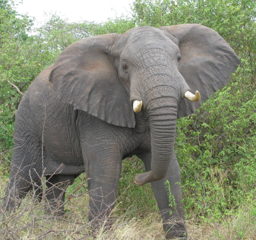

In [ ]:
#|eval: false
download_url(search_images_ddg('elephant', max_images=2)[1], 'elephant.jpg', show_progress=False)

im = Image.open('elephant.jpg')
im.to_thumb(256,256)

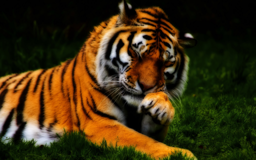

In [ ]:
#|eval: false
download_url(search_images_ddg('tiger', max_images=1)[0], 'tiger.jpg', show_progress=False)
Image.open('tiger.jpg').to_thumb(256,256)

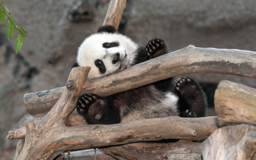

In [ ]:
#|eval: false
download_url(search_images_ddg('panda', max_images=1)[0], 'panda.jpg', show_progress=False)
Image.open('panda.jpg').to_thumb(256,256)

In [ ]:
import os

In [ ]:
#|exports
#|code-fold: true
def animals_folder_create(folder_path, animals):
    for i in animals:
        dest = (folder_path/i)
        dest.mkdir(exist_ok=True, parents=True)

In [ ]:
#|exports
#|code-fold: true
def download_animal_images(folder_path, animals):
    for j in animals:
        print("downloading images for:", j)
        download_images(
            folder_path/j,
            urls=search_images_ddg(f'{j} photo',200),
            n_workers=32
        )

In [ ]:
#|exports
#|code-fold: true
def verify_pics(folder_path):
    failed = verify_images(get_image_files(folder_path))
    failed.map(Path.unlink)
    print("Number of images failed", len(failed))

In [ ]:
#|exports
#|code-fold: true
def resize_pics(folder_path, animals):
    for k in animals:
        resize_images(
            folder_path/k,
            max_size=400,
            dest=folder_path/k,
            max_workers=8
        )
        print("resizing images for:", k)

In [ ]:
#|exports
#|code-fold: true
def data_folder(folder_path):
    if os.path.exists(folder_path):
        print("Folder already exists:", folder_path)
    else:
        
        animals = ('chimpanzee', 'elephant', 'giraffe',
                    'kangaroo','lion','panda','rabbit',
                    'rhino', 'tiger', 'wolf')    
        
        animals_folder_create(folder_path, animals)
        download_animal_images(folder_path, animals)
        verify_pics(folder_path)
        resize_pics(folder_path, animals)
        print("Folder created:", folder_path)
        

In [ ]:

#|code-fold: true
path = Path('animal_pics') #Replace with folder path

data_folder(path)

Folder already exists: animal_pics


## Step 2: Train our model

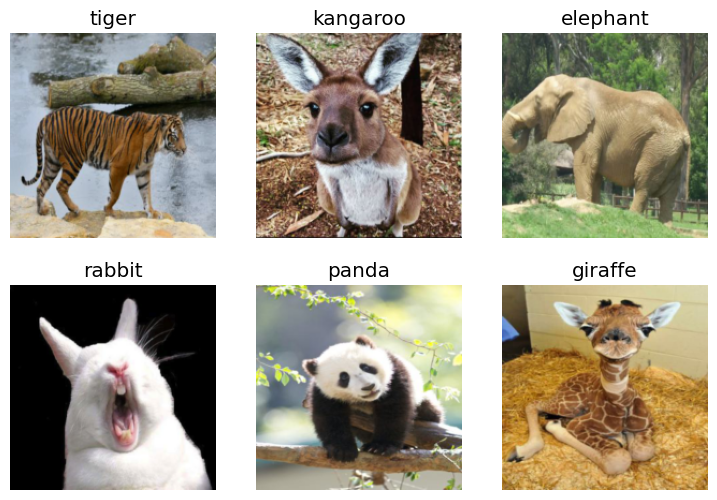

In [ ]:
#|eval: false
from fastai.metrics import accuracy, error_rate

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [ ]:
# Define your metrics
metrics = [accuracy, error_rate]

In [ ]:
#|eval: false
learn11 = vision_learner(dls, resnet18, metrics=metrics)
learn11.fine_tune(5)

/home/ben/mambaforge/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ben/mambaforge/envs/myenv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/ben/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|███████████████████████████████████████████████████████████████████| 44.7M/44.7M [01:18<00:00, 597kB/s]


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.777263,0.127826,0.962264,0.037736,00:09


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.150076,0.137703,0.969811,0.030189,00:06
1,0.098177,0.164293,0.966038,0.033962,00:05
2,0.060486,0.169164,0.966038,0.033962,00:06
3,0.040868,0.168313,0.969811,0.030189,00:06
4,0.028659,0.165864,0.969811,0.030189,00:05


## Step 3: Display Results: Confusion Matrix

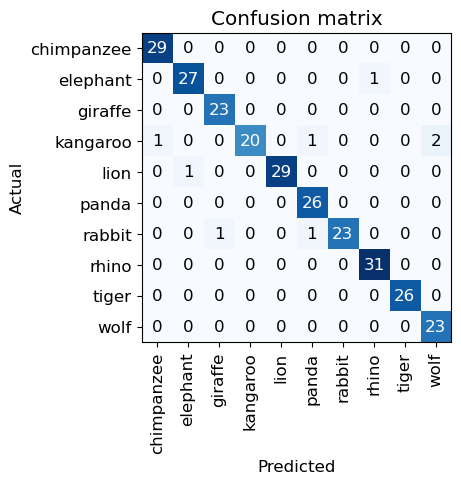

In [ ]:
#|eval: false
interp11 = ClassificationInterpretation.from_learner(learn11)
interp11.plot_confusion_matrix()

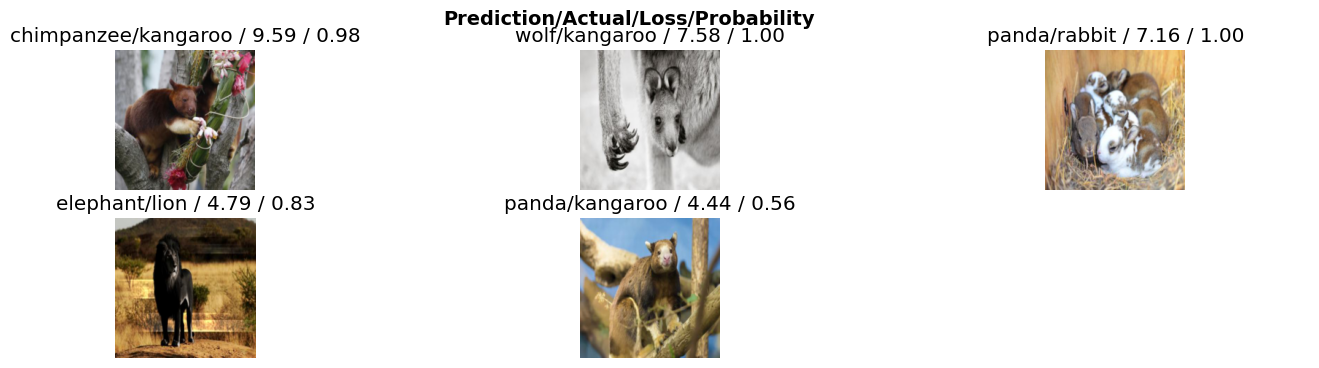

In [ ]:
#|eval: false
interp11.plot_top_losses(5,nrows = 2, figsize=(17,4))

## Step 4: Display Results: t-SNE

In [ ]:
from fastai.vision.all import *
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

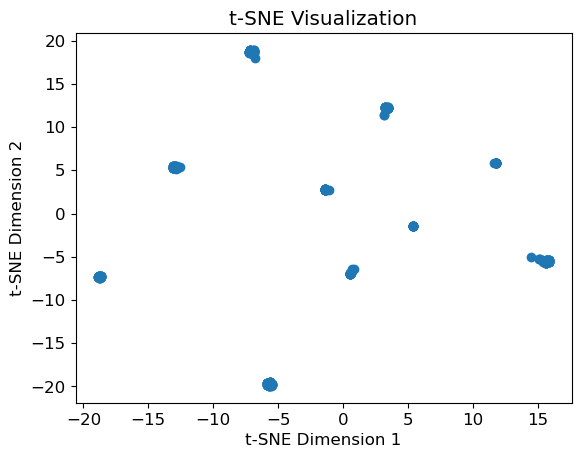

In [ ]:
#|eval: false
features, labels = learn11.get_preds(dl=dls.valid)

# Replace 'val_features' with your extracted features
tsne = TSNE(n_components=2)
reduced_features = tsne.fit_transform(features)

# Replace 'labels' with your image labels if available
plt.scatter(reduced_features[:, 0], reduced_features[:, 1])
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Visualization')
plt.show()

## Step 5: Use our model

This is a: elephant with probability: 0.9999945163726807.


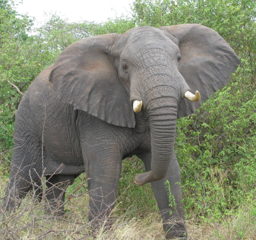

In [ ]:
#|eval: false
animal_list =  ('chimpanzee','elephant','giraffe',
                'kangaroo', 'lion','panda', 'rabbit',
                'rhino','tiger','wolf')
image= 'elephant.jpg'


is_real,_,probs = learn11.predict(PILImage.create(image))
max_value, max_index = torch.max(probs, dim=0)
print(f"This is a: {animal_list[max_index]} with probability: {max_value}.")

Image.open(image).to_thumb(256,256)

In [ ]:
#|eval: false
animal_list =  ('chimpanzee','elephant','giraffe',
                'kangaroo', 'lion','panda', 'rabbit',
                'rhino','tiger','wolf')
for index, value in enumerate(animal_list):
    np.set_printoptions(suppress=True, precision=4)
    print(f"Probability of {value} is :{probs[index]:4f}.")

Probability of chimpanzee is :0.000000.
Probability of elephant is :0.999995.
Probability of giraffe is :0.000000.
Probability of kangaroo is :0.000000.
Probability of lion is :0.000001.
Probability of panda is :0.000000.
Probability of rabbit is :0.000000.
Probability of rhino is :0.000004.
Probability of tiger is :0.000000.
Probability of wolf is :0.000000.
